In [1]:
!pip install pandas
!pip install statsmodels

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

## Prédiction du cumul mensuel des hauteurs de précipitation (en mm et 1/10)

In [3]:
dossier = './ds_outremer/SH_RR_Outremer/'
dfs = []

for fichier in os.listdir(dossier):
    if fichier.endswith('.csv'):
        chemin_fichier = os.path.join(dossier, fichier)
        df = pd.read_csv(chemin_fichier, delimiter=';', skiprows=12)
        dfs.append(df)

data_RR = pd.concat(dfs, ignore_index=True)
data_RR.head()
# data_RR.to_csv('./RR.csv', index=False)
data_RR['YYYYMM'] = pd.to_datetime(data_RR['YYYYMM'], format='%Y%m')
pd.DataFrame(data_RR.groupby(['YYYYMM']).sum())

,VALEUR,Q_HOM
YYYYMM,,
1950-01-01,1457.5,5
1950-02-01,503.9,5
1950-03-01,645.5,5
1950-04-01,589.1,5
1950-05-01,699.4,5
...,...,...
2022-08-01,16307.7,0
2022-09-01,13503.0,0
2022-10-01,9946.0,0


In [4]:
rr_mean = data_RR.groupby('YYYYMM').mean()
rr_mean_df = pd.DataFrame(rr_mean)
rr_mean_df = rr_mean_df.reset_index()

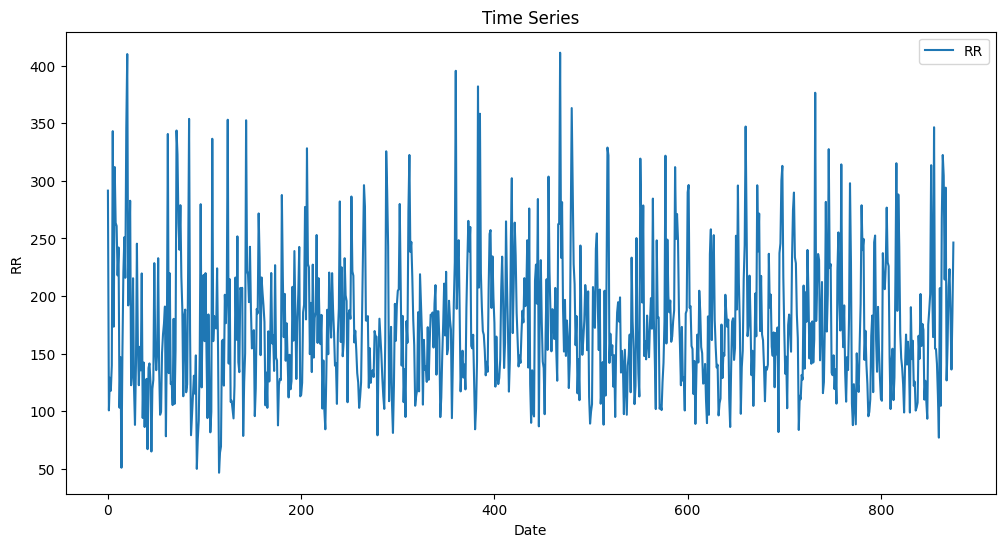

(-7.14985953845628,
 3.1617702944882324e-10,
 17,
 858,
 {'1%': -3.4379944895149097,
  '5%': -2.864914462846141,
  '10%': -2.5685668227188505},
 9120.14264253922)

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(rr_mean_df['VALEUR'], label='RR')
plt.title('Time Series')
plt.xlabel('Date')
plt.ylabel('RR')
plt.legend()
plt.show()

adf_rr_test_result = adfuller(rr_mean_df['VALEUR'])

adf_rr_test_result

In [6]:
multiplicative_decomposition_rr = seasonal_decompose(rr_mean['VALEUR'], model='multiplicative', period=12)

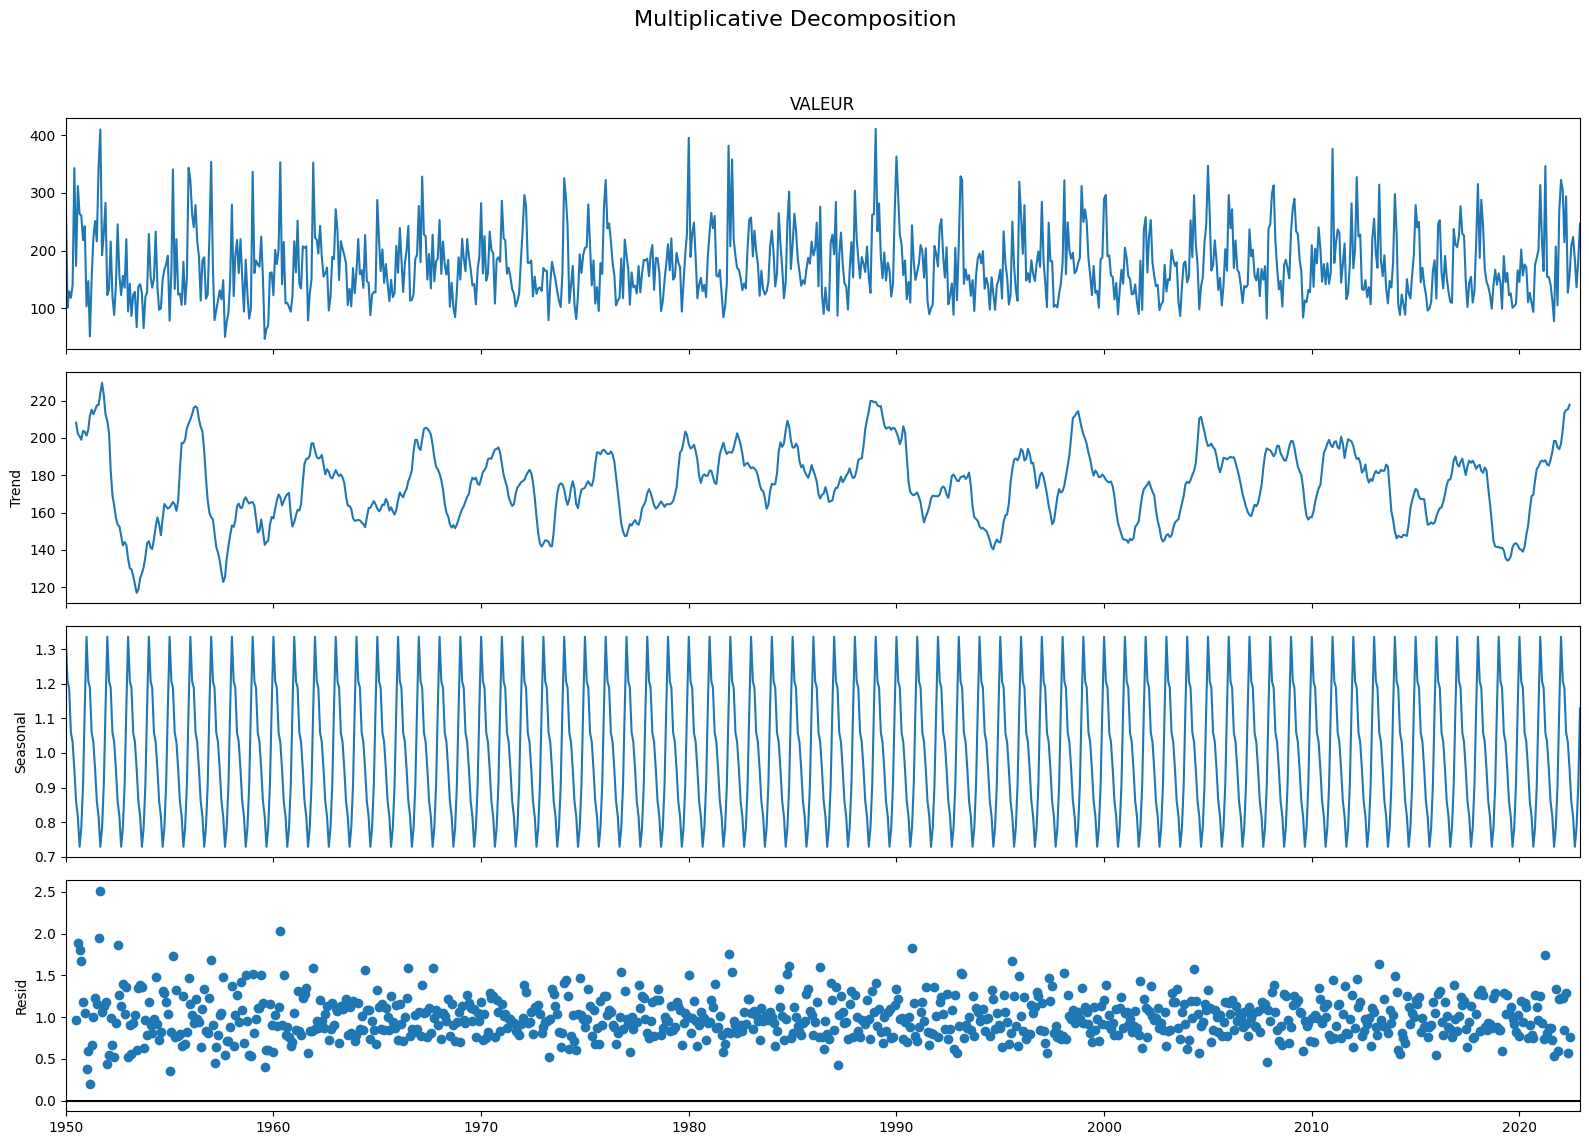

In [7]:
plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition_rr.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [8]:
data_length = len(rr_mean_df)
data_length

# Définir les indices pour diviser les données - 80% pour l'entraînement, 20% pour le test
train_size = int(data_length * 0.98)
test_size = data_length - train_size

# Préparer les séries d'apprentissage et de test
train_df = rr_mean_df.iloc[:train_size]
test_df = rr_mean_df.iloc[train_size:]

# Sélectionner la colonne 'RR' pour l'analyse
X_train = train_df['VALEUR']
X_test = test_df['VALEUR']

train_size, test_size

(858, 18)

c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


51.298987149341194


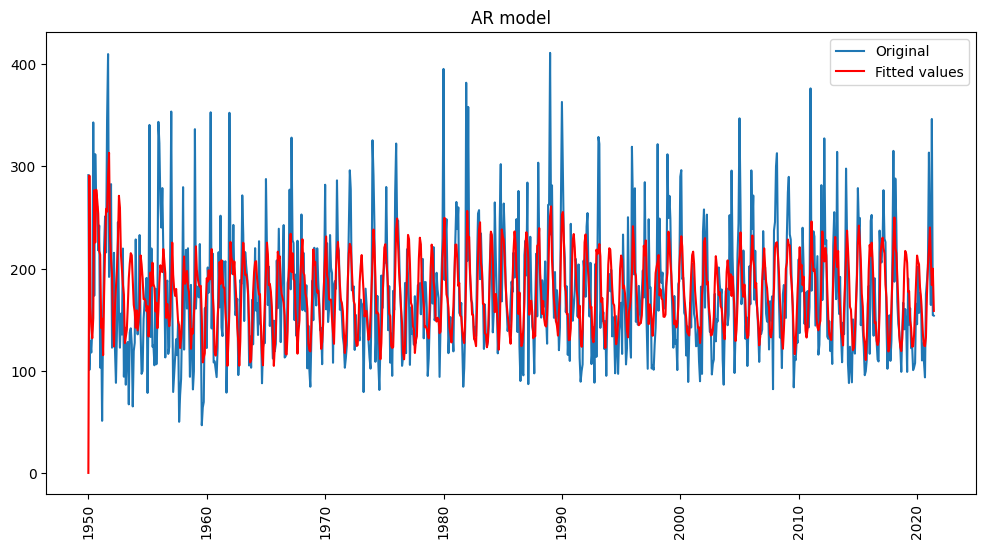

In [9]:
# Modèle ARIMA
model_ARIMA = ARIMA(X_train, order=(12, 1, 12))  
results_ARIMA = model_ARIMA.fit()

# Calculer le RMSE pour le modèle AR
rmse = sqrt(mean_squared_error(X_train, results_ARIMA.fittedvalues))
print(rmse)

plt.figure(figsize=(12, 6))
plt.plot(train_df['YYYYMM'], train_df['VALEUR'], label='Original')
plt.plot(train_df['YYYYMM'], results_ARIMA.fittedvalues, color='red', label='Fitted values')
plt.xticks(rotation=90)
plt.title('AR model')
plt.legend()
plt.show()

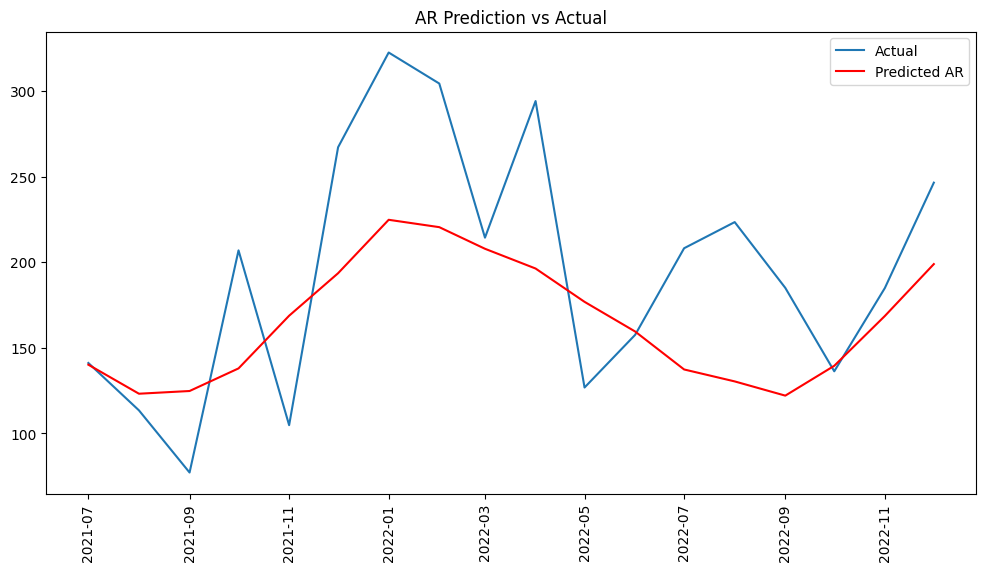

In [10]:
# Prédictions avec le modèle AR
predictions_AR = results_ARIMA.forecast(steps=test_size)

# Préparer la visualisation des prédictions AR vs valeurs réelles
plt.figure(figsize=(12, 6))
plt.plot(test_df['YYYYMM'], X_test, label='Actual')
plt.plot(test_df['YYYYMM'], predictions_AR, color='red', label='Predicted AR')
plt.xticks(rotation=90)
plt.title('AR Prediction vs Actual')
plt.legend()
plt.show()

## Prédiction de la moyenne mensuelle de la température minimale sous abri (en °C et 1/10)

In [11]:
dossier = './ds_outremer/SH_TN_Outremer/'
dfs = []

for fichier in os.listdir(dossier):
    if fichier.endswith('.csv'):
        chemin_fichier = os.path.join(dossier, fichier)
        df = pd.read_csv(chemin_fichier, delimiter=';', skiprows=12)
        dfs.append(df)

data_TN = pd.concat(dfs, ignore_index=True)
data_TN = data_TN.head(2000)
data_TN.head()
# data_TN.to_csv('./TN.csv', index=False)
data_TN['YYYYMM'] = pd.to_datetime(data_TN['YYYYMM'], format='%Y%m')
pd.DataFrame(data_TN.groupby(['YYYYMM']).mean())

,VALEUR,Q_HOM
YYYYMM,,
1955-01-01,20.10,1.0
1955-02-01,20.50,1.0
1955-03-01,20.60,1.0
1955-04-01,20.30,1.0
1955-05-01,20.50,1.0
...,...,...
2022-08-01,19.10,0.0
2022-09-01,19.50,0.0
2022-10-01,19.95,0.0


In [12]:
tn_mean = data_TN.groupby('YYYYMM').mean()
tn_mean_df = pd.DataFrame(tn_mean)
tn_mean_df = tn_mean_df.reset_index()

In [13]:
additive_decomposition_tn = seasonal_decompose(tn_mean_df['VALEUR'], model='additive', period=12)

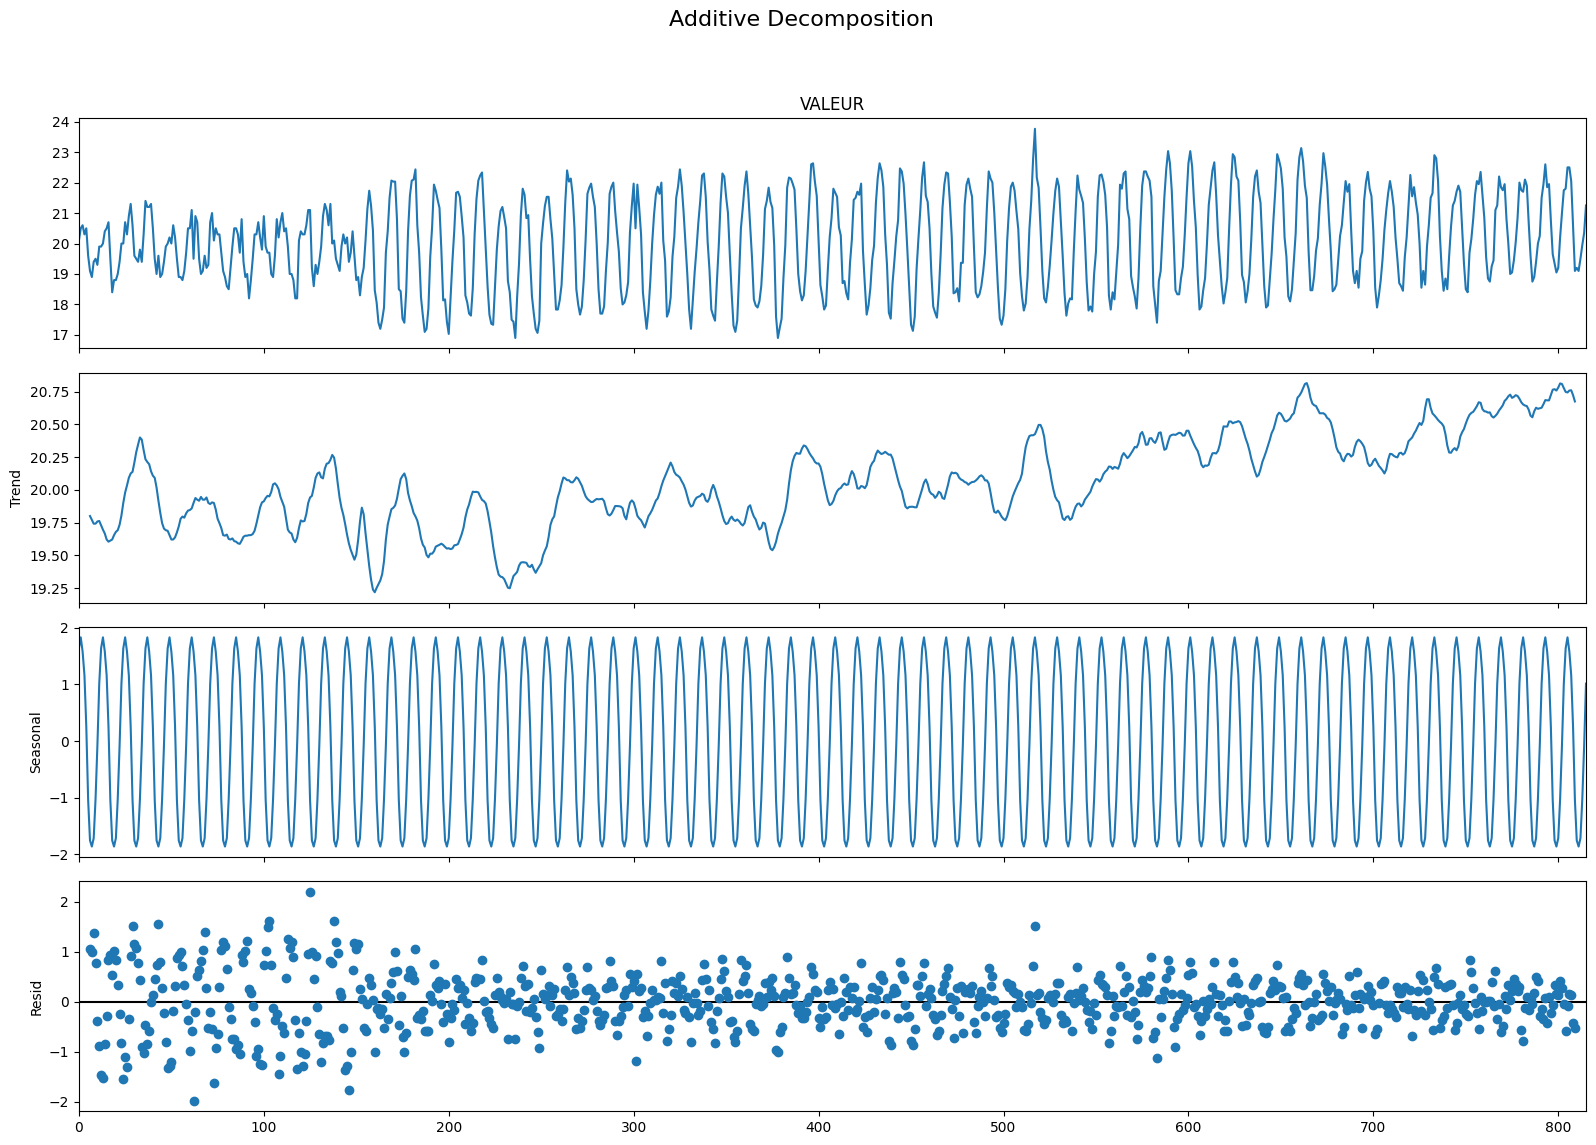

In [14]:
plt.rcParams.update({'figure.figsize': (16,12)})
additive_decomposition_tn.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [15]:
data_length = len(tn_mean_df)
data_length

# Définir les indices pour diviser les données - 80% pour l'entraînement, 20% pour le test
train_size = int(data_length * 0.98)
test_size = data_length - train_size

# Préparer les séries d'apprentissage et de test
train_df = rr_mean_df.iloc[:train_size]
test_df = rr_mean_df.iloc[train_size:]

# Sélectionner la colonne 'RR' pour l'analyse
X_train = train_df['VALEUR']
X_test = test_df['VALEUR']

train_size, test_size

(799, 17)

c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


53.57137267343415


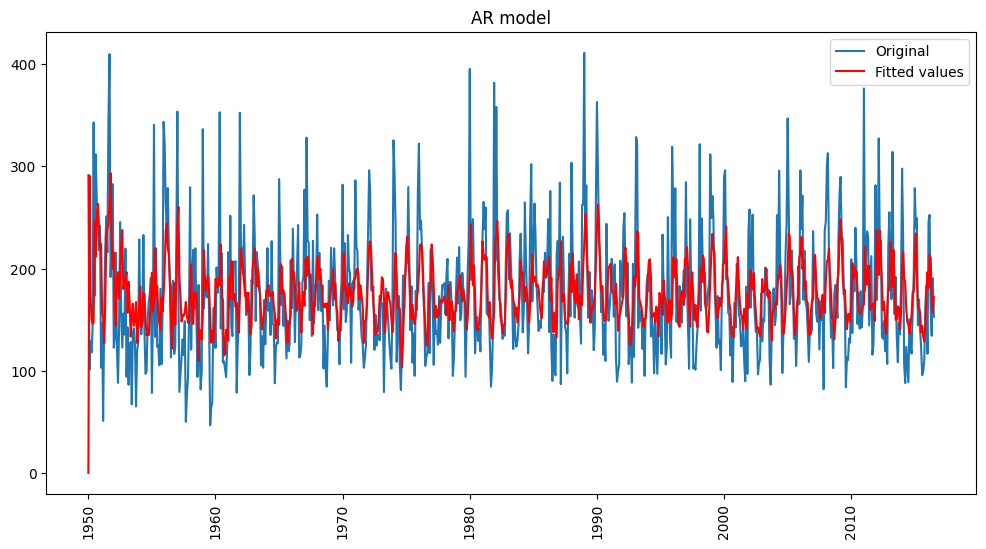

In [16]:
# Modèle ARIMA
model_ARIMA = ARIMA(X_train, order=(12, 1, 24))  
results_ARIMA = model_ARIMA.fit()

# Calculer le RMSE pour le modèle AR
rmse = sqrt(mean_squared_error(X_train, results_ARIMA.fittedvalues))
print(rmse)

plt.figure(figsize=(12, 6))
plt.plot(train_df['YYYYMM'], train_df['VALEUR'], label='Original')
plt.plot(train_df['YYYYMM'], results_ARIMA.fittedvalues, color='red', label='Fitted values')
plt.xticks(rotation=90)
plt.title('AR model')
plt.legend()
plt.show()

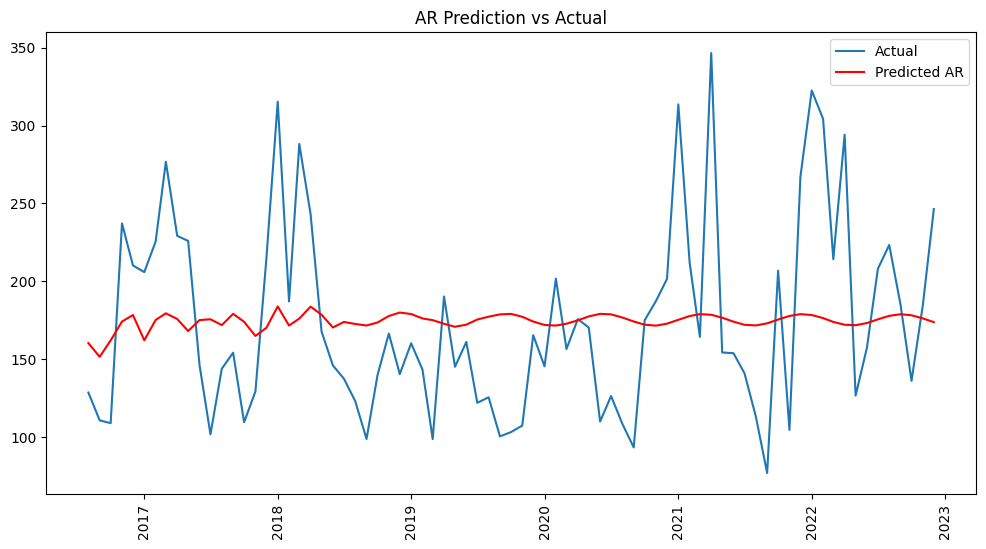

In [17]:
# Prédictions avec le modèle AR
predictions_AR = results_ARIMA.forecast(steps=77)

# Préparer la visualisation des prédictions AR vs valeurs réelles
plt.figure(figsize=(12, 6))
plt.plot(test_df['YYYYMM'], X_test, label='Actual')
plt.plot(test_df['YYYYMM'], predictions_AR, color='red', label='Predicted AR')
plt.xticks(rotation=90)
plt.title('AR Prediction vs Actual')
plt.legend()
plt.show()

In [18]:
predictions_AR.shape

(77,)

## Prédiction de la moyenne mensuelle de la température maximale sous abri (en °C et 1/10)

In [19]:
dossier = './ds_outremer/SH_TX_Outremer/'
dfs = []

for fichier in os.listdir(dossier):
    if fichier.endswith('.csv'):
        chemin_fichier = os.path.join(dossier, fichier)
        df = pd.read_csv(chemin_fichier, delimiter=';', skiprows=12)
        dfs.append(df)

data_TX = pd.concat(dfs, ignore_index=True)
data_TX = data_TX.head(2000)
# data_TX.to_csv('./TX.csv', index=False)
data_TX['YYYYMM'] = pd.to_datetime(data_TX['YYYYMM'], format='%Y%m')
pd.DataFrame(data_TX.groupby(['YYYYMM']).mean())

,VALEUR,Q_HOM
YYYYMM,,
1955-01-01,30.90,1.0
1955-02-01,29.50,1.0
1955-03-01,30.30,1.0
1955-04-01,30.70,1.0
1955-05-01,30.40,1.0
...,...,...
2022-08-01,31.30,0.0
2022-09-01,32.10,0.0
2022-10-01,31.80,0.0


In [20]:
tx_mean = data_TX.groupby('YYYYMM').mean()
tx_mean_df = pd.DataFrame(tx_mean)
tx_mean_df = tx_mean_df.reset_index()

In [21]:
additive_decomposition_tx = seasonal_decompose(tx_mean_df['VALEUR'], model='additive', period=12)

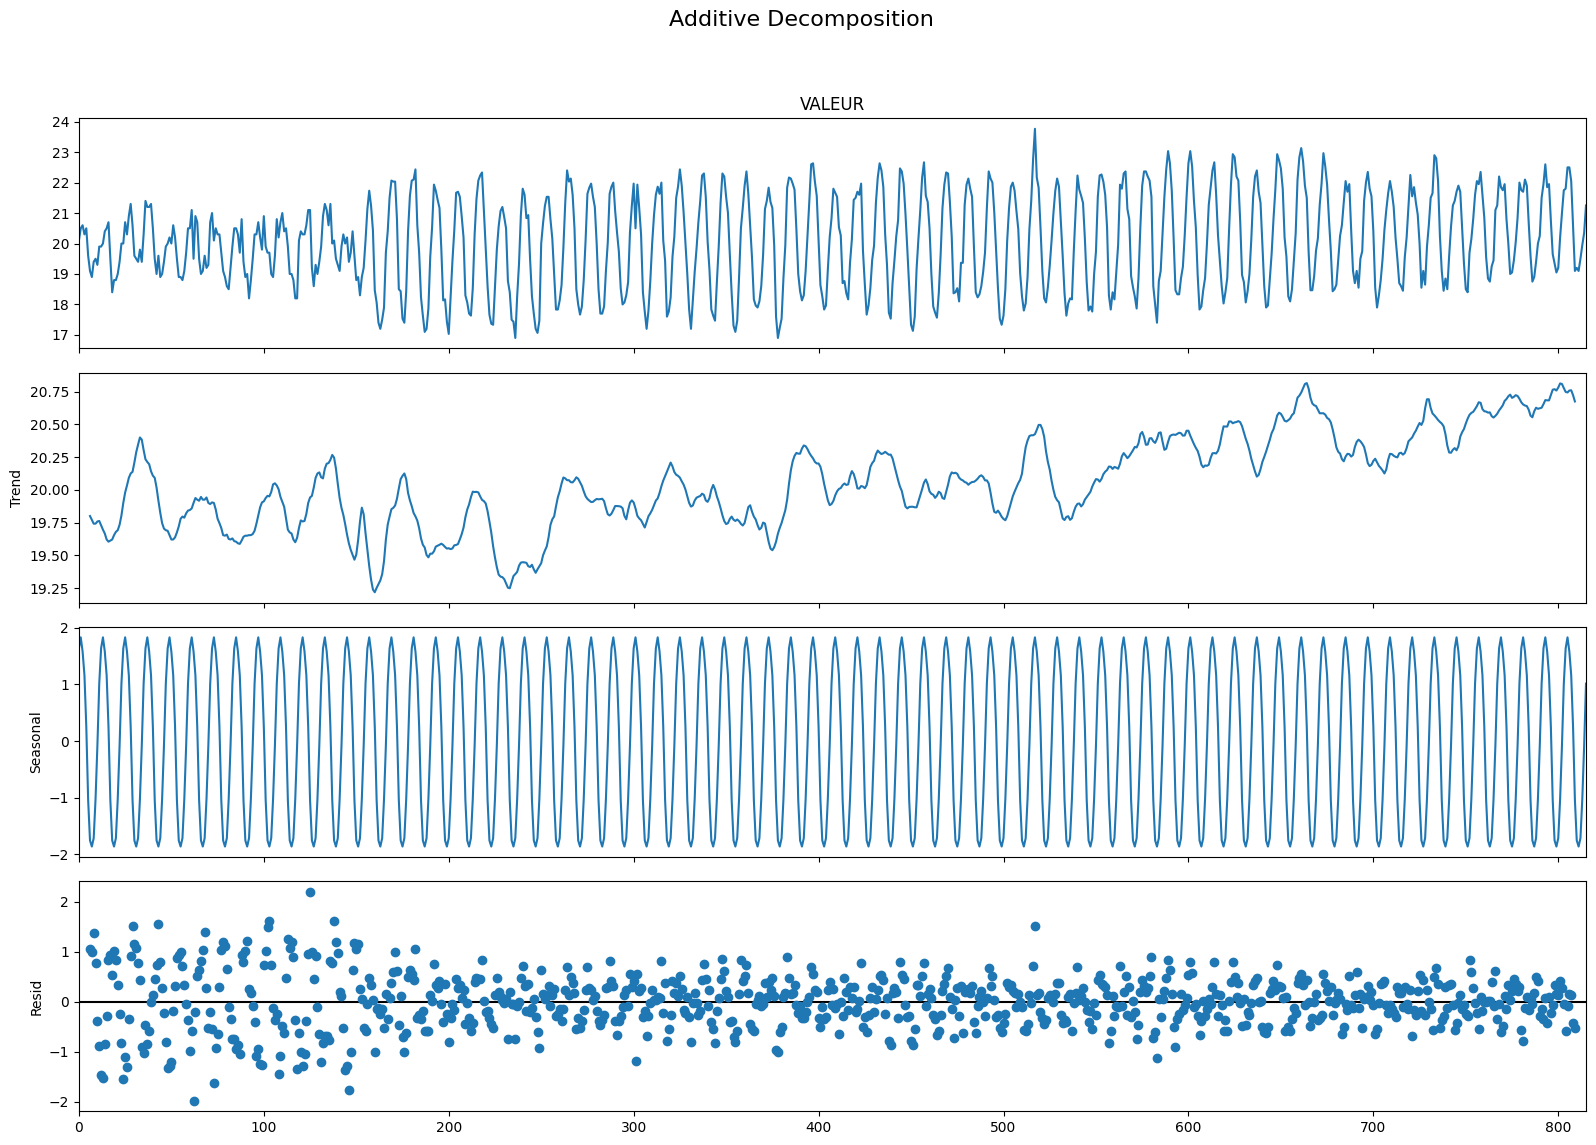

In [22]:
plt.rcParams.update({'figure.figsize': (16,12)})
additive_decomposition_tn.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [23]:
data_length = len(tx_mean_df)
data_length

# Définir les indices pour diviser les données - 80% pour l'entraînement, 20% pour le test
train_size = int(data_length * 0.98)
test_size = data_length - train_size

# Préparer les séries d'apprentissage et de test
train_df = rr_mean_df.iloc[:train_size]
test_df = rr_mean_df.iloc[train_size:]

# Sélectionner la colonne 'RR' pour l'analyse
X_train = train_df['VALEUR']
X_test = test_df['VALEUR']

train_size, test_size

(799, 17)

c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


53.57137267343415


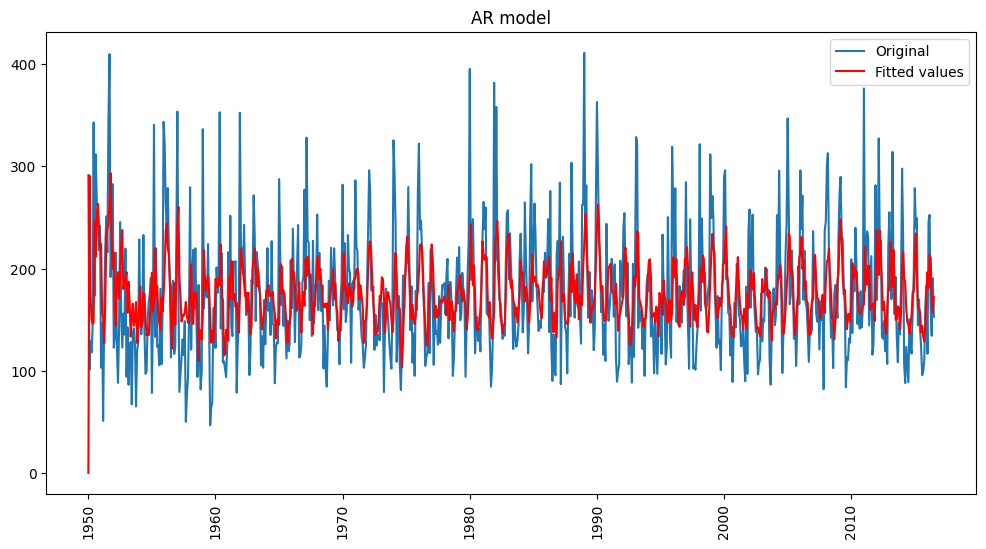

In [24]:
# Modèle ARIMA
model_ARIMA = ARIMA(X_train, order=(12, 1, 24))  
results_ARIMA = model_ARIMA.fit()

# Calculer le RMSE pour le modèle AR
rmse = sqrt(mean_squared_error(X_train, results_ARIMA.fittedvalues))
print(rmse)

plt.figure(figsize=(12, 6))
plt.plot(train_df['YYYYMM'], train_df['VALEUR'], label='Original')
plt.plot(train_df['YYYYMM'], results_ARIMA.fittedvalues, color='red', label='Fitted values')
plt.xticks(rotation=90)
plt.title('AR model')
plt.legend()
plt.show()

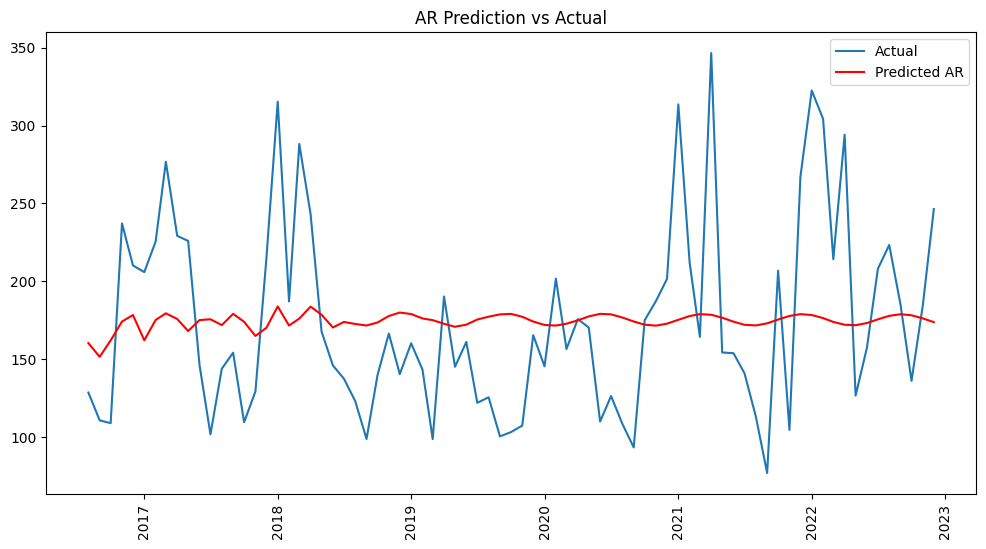

In [34]:
# Prédictions avec le modèle AR
predictions_AR = results_ARIMA.forecast(steps=77)

# Préparer la visualisation des prédictions AR vs valeurs réelles
plt.figure(figsize=(12, 6))
plt.plot(test_df['YYYYMM'], X_test, label='Actual')
plt.plot(test_df['YYYYMM'], predictions_AR, color='red', label='Predicted AR')
plt.xticks(rotation=90)
plt.title('AR Prediction vs Actual')
plt.legend()
plt.show()